Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install wandb -qU

In [3]:
# Log in to your W&B account
# 37c8a07c774e2e083984fb1eecd48091d723d40f
import wandb
wandb.login()

wandb: Currently logged in as: k-kiron (animal-detect-vit). Use `wandb login --relogin` to force relogin


True

In [4]:
import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [5]:
import sys
import cv2 # Pour utiliser opencv-python, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim

np.random.seed(0)

In [6]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
DATA_FOLDER_PATH = '/content/drive/MyDrive/IFT3710/Animals_with_Attributes2/'
JPEGIMAGES_FOLDER_PATH = '/content/drive/MyDrive/IFT3710/Animals_with_Attributes2/JPEGImages/'

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [7]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH): #-> tuple[dict,dict]: 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()
print(num_images_per_label)
print(proportions_images_per_label)

{'elephant': 1038, 'lion': 1019, 'deer': 1344, 'cow': 1338, 'squirrel': 1200, 'german+shepherd': 1033, 'skunk': 188, 'horse': 1645, 'mole': 100, 'walrus': 215, 'weasel': 282, 'mouse': 185, 'buffalo': 904, 'grizzly+bear': 852, 'bat': 383, 'chimpanzee': 728, 'beaver': 193, 'rabbit': 1088, 'wolf': 589, 'bobcat': 630, 'seal': 988, 'collie': 1028, 'spider+monkey': 291, 'otter': 758, 'rat': 310, 'leopard': 720, 'zebra': 1170, 'sheep': 1420, 'blue+whale': 174, 'ox': 728, 'chihuahua': 567, 'hamster': 779, 'tiger': 877, 'giraffe': 1202, 'polar+bear': 868, 'dolphin': 946, 'fox': 664, 'siamese+cat': 500, 'persian+cat': 747, 'raccoon': 512, 'antelope': 1046, 'pig': 713, 'giant+panda': 874, 'killer+whale': 291, 'moose': 704, 'dalmatian': 549, 'humpback+whale': 709, 'gorilla': 872, 'rhinoceros': 696, 'hippopotamus': 684}
{'elephant': 0.0278, 'lion': 0.0273, 'deer': 0.036, 'cow': 0.0358, 'squirrel': 0.0321, 'german+shepherd': 0.0277, 'skunk': 0.005, 'horse': 0.0441, 'mole': 0.0027, 'walrus': 0.0058, 

In [8]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """
    
    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

#
create_annotations_csv_file()

Deleted existent annotations.csv file.
 ---------------------------
Sucessfully created annotations.csv file.


In [9]:
# labels_in_number = pd.read_csv(DATA_FOLDER_PATH+"classes.txt", delim_whitespace=True,header=None)
labels_dict = {}
with open(DATA_FOLDER_PATH+"classes.txt") as f:
    for line in f:
        # print(line.split())
        (key,val) = line.split()
        labels_dict[val] = int(key)-1
print(labels_dict)

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49}


In [10]:
from torchvision.io import read_image, ImageReadMode
from PIL import Image


class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        key = self.img_labels.iloc[idx, 1]

        # Mapping the labels from string to tensor
        label = labels_dict[key]

        image = read_image(path = img_path, mode = ImageReadMode.RGB)
        # with open(img_path, 'rb') as f:
        #     image = Image.open(f)
        #     image = image.convert('RGB')  # convert to RGB


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class Subset_(AWA2Dataset) : 
    def __init__(self, dataset, indices, transform=None):
        super().__init__()
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        original_index_in_AWA2Dataset = self.indices[index]
        image, label = self.dataset[original_index_in_AWA2Dataset]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    

In [11]:
# dataset = AWA2Dataset()
# image,label = dataset[4125]



# ## TODO : Change transforms. Currently this is not useful.
# dataset.transform = transforms.Compose([
#                         transforms.ToPILImage(),
#                         transforms.Resize((224, 224)),
#                         # transforms.RandomHorizontalFlip(),
#                         transforms.Grayscale(num_output_channels=3),
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.485, 0.456, 0.406), 
#                                              (0.229, 0.224, 0.225))])

# # Testing. All good
# random_index = np.random.randint(0, len(dataset))
# image, label = dataset[random_index]

In [12]:
transforms_pipeline_train = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    
                    ## Data augmentation 
                    transforms.RandomRotation(15),
                    transforms.RandomHorizontalFlip(p=0.4),
                    # transforms.RandomApply(transforms.RandAugment(), p=0.4), # 40% of the time, apply a random additional combo of transformations #https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
                    transforms.ColorJitter(brightness=0.2,
                                            contrast=0.2,
                                            saturation=0.2,
                                            hue=0.1),
                    transforms.RandomCrop((224,224)),  # transforms.RandomResizedCrop(size=(224,224), scale=(0.6, 0.9), ratio=(0.5, 1.08,))
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


transforms_pipeline_test = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    transforms.CenterCrop((224,224)),   
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


### ViT ###

### Pre-trained ViT ###

In [13]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from timm.models import create_model
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

dataset = AWA2Dataset()

vit_model = create_model('vit_base_patch16_224', pretrained=True, num_classes=50)
vit_model.eval()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(vit_model.head.parameters(), lr=0.001)

# train_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()

#         # forward
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # backward
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=F

### CUDA ###

In [15]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [16]:
torch.cuda.is_available()

True

In [17]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7503246013494714059
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 39552876544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9774206033099380498
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [18]:
vit_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=F

### Question: check dimension de dataloader   ###

###  Split training data and test data ###

In [19]:
# Initialize dataset and train/valid/test split 
from sklearn.model_selection import train_test_split

dataset = AWA2Dataset()
n_images = len(dataset)
# Split all indices into training/testing sets
train_indices, test_indices = train_test_split(range(n_images), test_size=0.2, random_state=1)
# Split training indices into training/validation sets.
train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=1)


# Initialize the 3 DataSet objects (as Subset_) and apply the relevant Transforms to each subset (train/test/valid)
train_data = Subset_(dataset, train_indices, transform = transforms_pipeline_train)
valid_data = Subset_(dataset, valid_indices, transform = transforms_pipeline_test)
test_data  = Subset_(dataset, test_indices, transform = transforms_pipeline_test) 

# Initalize DataLoaders
batch_size = 128

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

###   transfomer labels  ###

In [20]:
path_class = DATA_FOLDER_PATH +"classes.txt"
class_animal = pd.read_table(path_class,header= None)

In [21]:
animals = class_animal[1]
dict_label_animal = {}
n = 0
for i in range(0,len(animals)):
    dict_label_animal[animals[i]] = n
    n+=1
def label_to_num(tuple_labels):
    list_labels =[]
    for tuple_label in tuple_labels:
        list_labels.append(dict_label_animal[tuple_label])
    return torch.tensor(list_labels) 

###  Training  ###

In [22]:
# pip install --upgrade timm

In [23]:
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm



# loss function
# criterion = nn.CrossEntropyLoss()
# # optimizer
# optimizer = optim.Adam(vit_model.parameters(), lr=1e-4, weight_decay=1e-5) ### Added weight decay 
# # scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.head.parameters(), lr=1e-4)


wandb.init(
    # set the wandb project where this run will be logged
    project="Pre_ViT-B_16_224",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "ViT",
    "dataset": "AWA2",
    "epochs": 10,
    }
)

for epoch in range(10):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = vit_model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # scheduler.step() ### SHOULD BE HERE 

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = vit_model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    # log metrics to wandb
    wandb.log({"loss" : epoch_loss , "acc": epoch_accuracy, "val_loss" : epoch_val_loss, "val_acc": epoch_val_accuracy})


# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.5077 - acc: 0.6696 - val_loss : 0.3285 - val_acc: 0.9286



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.3224 - acc: 0.9187 - val_loss : 0.1916 - val_acc: 0.9508



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.2330 - acc: 0.9356 - val_loss : 0.1592 - val_acc: 0.9549



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.2014 - acc: 0.9404 - val_loss : 0.1437 - val_acc: 0.9576



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.1786 - acc: 0.9461 - val_loss : 0.1355 - val_acc: 0.9591



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.1668 - acc: 0.9494 - val_loss : 0.1300 - val_acc: 0.9603



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.1532 - acc: 0.9535 - val_loss : 0.1244 - val_acc: 0.9625



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.1506 - acc: 0.9523 - val_loss : 0.1243 - val_acc: 0.9621



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.1381 - acc: 0.9574 - val_loss : 0.1199 - val_acc: 0.9634



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.1333 - acc: 0.9580 - val_loss : 0.1187 - val_acc: 0.9633



acc,▁▇▇███████
loss,█▂▂▁▁▁▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▃▂▂▂▁▁▁▁▁
acc,0.958
loss,0.13327
val_acc,0.96328
val_loss,0.11873


In [24]:
# save model to file in Google Drive
model_path = '/content/drive/MyDrive/IFT3710/ViT/pre-vit-b_16_224.pth'
torch.save(vit_model.state_dict(), model_path)

In [25]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="test",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 1e-3,
#     "architecture": "ViT",
#     "dataset": "AWA2",
#     "epochs": 50,
#     }
# )

# vit_model.train()

# for epoch in range(50):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs = data[0].to(device)
#         # print(inputs)
#         labels = data[1].to(device)
#         # print(labels)
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         output = vit_model(inputs)
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()

#         print('[%d, %5d] loss: %.3f' %
#               (epoch + 1, i + 1, running_loss ))
        
#         # acc
#         print('current batch acc', (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0))
        
#         # log metrics to wandb
#         wandb.log({"loss": running_loss, "acc": (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0)})

#         running_loss = 0.0

        


# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()

# print('Finished Training of ViT')

In [26]:
# (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0)

### Test ###

In [27]:
!pip install -Uqq ipdb
import ipdb
%pdb off

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.0 MB/s eta 0:00:00
Automatic pdb calling has been turned OFF


In [29]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)#suggested_max_workers_for_colab_env = 6
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

correct = 0
total = 0
y_true = []
y_pred = []
wrong_pred =[]
right_label = []
with torch.no_grad():
    # for data in test_loader:
    for data in tqdm(test_loader):
    # for data, labels in tqdm(test_loader) :
        # data = data.to(device)
        # labels = label.to(device)
        # output = vit_model(data)
        
        images = data[0].to(device)
        labels = data[1].to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        # ipdb.set_trace(context=6)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
        # ipdb.set_trace(context=6)
        total += labels.size(0)
        
        for i in range(0,len(predicted)):
              if predicted[i].item() != labels[i].item():
                    wrong_pred.append(predicted[i].item())
                    right_label.append(labels[i].item())
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

  0%|          | 0/59 [00:00<?, ?it/s]

Accuracy of the network on the test images: 96 %


###   Analyse  ###

In [31]:
# pip install pandas

In [30]:
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt

In [32]:
nb_wrong_pred = []
for i in range(0,50):
    nb_wrong_pred.append(wrong_pred.count(i))

In [33]:
list_animal = list(dict_label_animal.keys())

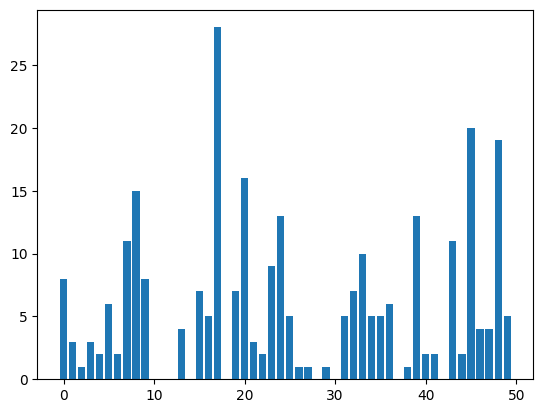

In [34]:
plt.bar(range(50), nb_wrong_pred)
plt.show()

In [35]:
good_classification = []
bad_classification = []
for i in range(50):
    if nb_wrong_pred[i]<=5:
        good_classification.append(i)
    if    nb_wrong_pred[i]>=60:
        bad_classification.append(i)

In [36]:
def find_right_animal(m):
    wrong_pred_m =[]
    for j in [i for i,x in enumerate(wrong_pred) if x == m]:
        wrong_pred_m.append(right_label[j])
    return list_animal[max(wrong_pred_m,key = wrong_pred_m.count)]

In [37]:
for i in good_classification :
    print('ViT a bien classifie '+animals[i])

ViT a bien classifie grizzly+bear
ViT a bien classifie killer+whale
ViT a bien classifie beaver
ViT a bien classifie dalmatian
ViT a bien classifie horse
ViT a bien classifie skunk
ViT a bien classifie mole
ViT a bien classifie tiger
ViT a bien classifie hippopotamus
ViT a bien classifie leopard
ViT a bien classifie spider+monkey
ViT a bien classifie elephant
ViT a bien classifie fox
ViT a bien classifie sheep
ViT a bien classifie hamster
ViT a bien classifie squirrel
ViT a bien classifie rhinoceros
ViT a bien classifie rabbit
ViT a bien classifie bat
ViT a bien classifie giraffe
ViT a bien classifie wolf
ViT a bien classifie weasel
ViT a bien classifie otter
ViT a bien classifie zebra
ViT a bien classifie giant+panda
ViT a bien classifie bobcat
ViT a bien classifie pig
ViT a bien classifie lion
ViT a bien classifie polar+bear
ViT a bien classifie walrus
ViT a bien classifie raccoon
ViT a bien classifie dolphin


In [38]:
for i in bad_classification:
    print('ViT a mal classifie '+animals[i]+' , melange souvent avec '+find_right_animal(i))

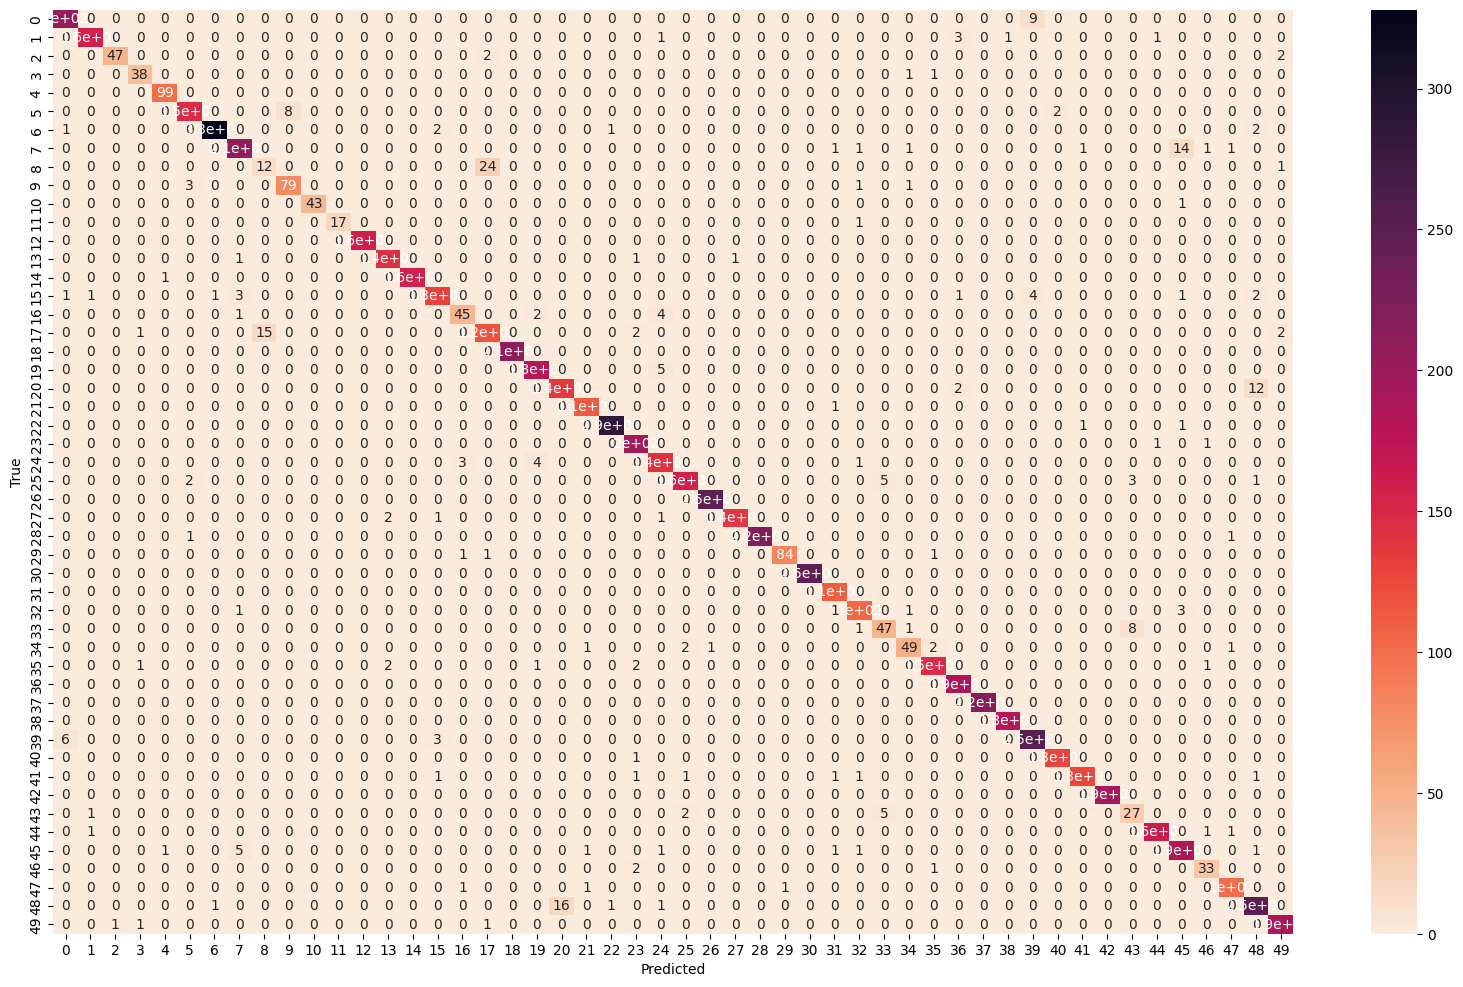

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, y_pred)

# Seaborn heatmap
fig, ax = plt.subplots(figsize=(20,12))  
sns.heatmap(confusion_mat, annot=True, cmap='rocket_r')

# set plot labels
plt.xlabel('Predicted')
plt.ylabel('True')

# show plot
plt.show()